   Unnamed: 0   obecA   obecB  pocet  okresA  okresB obecA_nazov  \
0           1  507300  507300     18  SK0318  SK0318   Ivachnová   
1           2  507300  507407      1  SK0318  SK0318   Ivachnová   
2           3  507300  510262     10  SK0318  SK0315   Ivachnová   
3           4  507300  510301      6  SK0318  SK0318   Ivachnová   
4           5  507300  510386      1  SK0318  SK0315   Ivachnová   

         obecB_nazov kod_start      start_x       start_y kod_dest  \
0          Ivachnová    507300  -395493.798  -1190259.070   507300   
1              Turík    507300  -395493.798  -1190259.070   507407   
2  Liptovský Mikuláš    507300  -395493.798  -1190259.070   510262   
3           Bešeňová    507300  -395493.798  -1190259.070   510301   
4  Demänovská Dolina    507300  -395493.798  -1190259.070   510386   

         end_x         end_y                         geometry  
0  -395493.798  -1190259.070  POINT (-395493.798 -1190259.07)  
1  -397590.562  -1188467.760  POINT (-3954

<Figure size 827x1169 with 0 Axes>

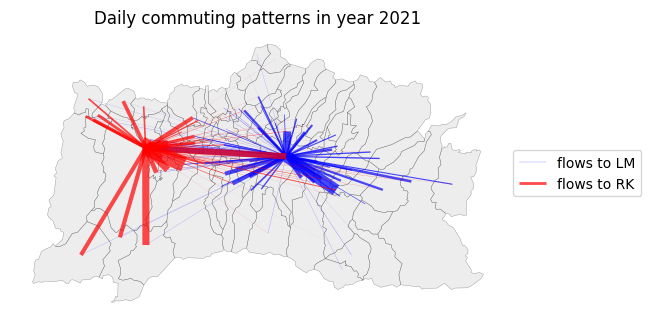

In [65]:
import geopandas as gpd
import pandas as pd
import numpy as np
import mapclassify
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib .patches import Patch, Rectangle
from shapely.geometry import Point
from shapely.geometry import LineString

f = pd.read_csv(r"../data/sodb_2021_dochadzka_denne_lm_rk.csv", encoding="windows-1250")

b = gpd.read_file(r"../data/liptov_obce.csv", encoding = "windows-1250")

f["obecA"] = f["obecA"].astype(str)
f["obecB"] = f["obecB"].astype(str)
b["kod"] = b["kod"].astype(str)
f = f.merge(
    b[["kod", "x", "y"]],
    left_on = "obecA",
    right_on = "kod",
    how = "left"
).rename(columns={"x": "start_x", "y": "start_y", "kod": "kod_start"})

f = f.merge(
    b[["kod", "x", "y"]],
    left_on = "obecB",
    right_on = "kod",
    how = "left"
).rename(columns={"x": "end_x", "y": "end_y", "kod": "kod_dest"})
commuting_gdf = gpd.GeoDataFrame(
    f,
    geometry=[Point(xy) for xy in zip(f["start_x"], f["start_y"])],
    crs="EPSG:5514"
)
print(commuting_gdf.head())

background = gpd.read_file(r"../data/geo/liptov.shp")
flows_selected = f[f["kod_dest"].isin(["510262", "510998"])].copy()


flows_selected["geometry"] = flows_selected.apply(
    lambda row: LineString([(row["start_x"], row["start_y"]), (row["end_x"], row["end_y"])]),
    axis = 1
)

line_gdf = gpd.GeoDataFrame(flows_selected, geometry = "geometry", crs="EPSG:5514")

flows_510262 = line_gdf[line_gdf["kod_dest"] == "510262"]
flows_510998 = line_gdf[line_gdf["kod_dest"] == "510998"]

plt.figure(figsize = (8.27, 11.69))


ax = background.plot(
    alpha = 0.4,
    edgecolor = "black",
    color = "lightgray",
    linewidth = 0.3
)

flows_510262.plot(
    ax = ax,
    linewidth = flows_510262["pocet"] / flows_510262["pocet"].max()*100,
    alpha = 0.7,
    color = "blue",
    label = "flows to LM"
)

flows_510998.plot(
    ax = ax,
    linewidth = flows_510998["pocet"] / flows_510998["pocet"].max()*100,
    alpha = 0.7,
    color = "red",
    label = "flows to RK"
)

plt.legend(
    loc = "center left",
    bbox_to_anchor = (1, 0.5),
    frameon = True
)

plt.title("Daily commuting patterns in year 2021")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis(False)

plt.grid(False)

plt.savefig("../result_maps/test_LM_RK_1.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()

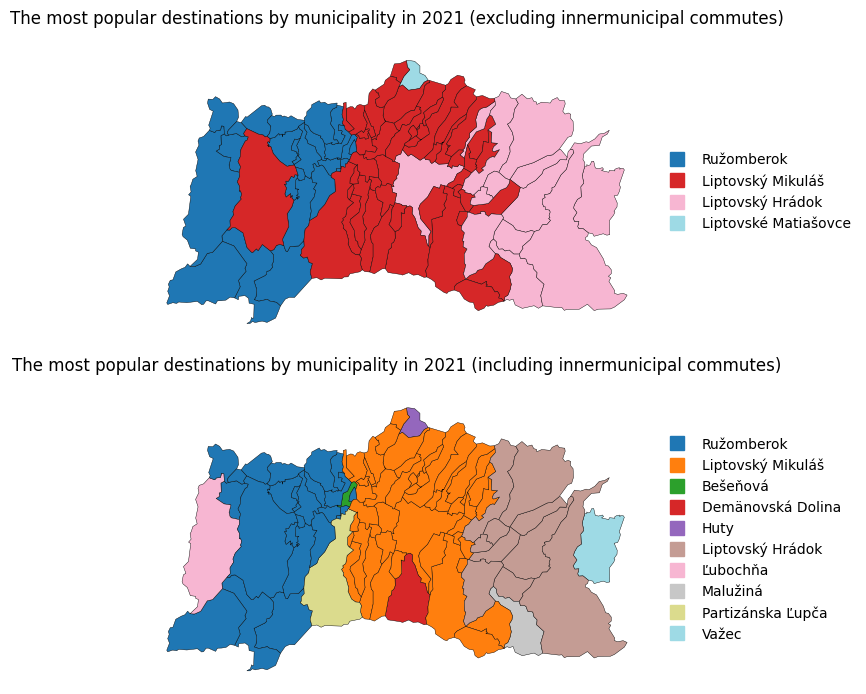

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import mapclassify
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib .patches import Patch, Rectangle
from shapely.geometry import Point
from shapely.geometry import LineString

commuting = pd.read_csv(r"../data/sodb_2021_dochadzka_denne_lm_rk.csv", encoding="windows-1250")

map = gpd.read_file(r"../data/geo/liptov.shp")

commuting[["obecA", "obecB"]] = commuting[["obecA", "obecB"]].astype(str)
map["IDN4"] = map["IDN4"].astype(str)

most_popular = (
    commuting[commuting["obecA"] != commuting["obecB"]]
    .groupby("obecA", group_keys = False)[["obecA", "obecB", "obecB_nazov", "pocet"]]
    .apply(lambda x: x.loc[x["pocet"].idxmax()])
    .reset_index(drop = True)
)

result = map.merge(
    most_popular[["obecA", "obecB", "obecB_nazov"]],
    left_on = "IDN4",
    right_on = "obecA",
    how = "left"
).rename(columns={"IDN4": "kod_start"})
unique_dest = result["obecB_nazov"].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_dest)))
color_dict = dict(zip(unique_dest, colors))

most_popular2 = (
    commuting
    .groupby("obecA", group_keys = False)[["obecA", "obecB", "obecB_nazov", "pocet"]]
    .apply(lambda x: x.loc[x["pocet"].idxmax()])
    .reset_index(drop = True)
)

result2 = map.merge(
    most_popular2[["obecA", "obecB", "obecB_nazov"]],
    left_on = "IDN4",
    right_on = "obecA",
    how = "left"
).rename(columns={"IDN4": "kod_start"})
unique_dest2 = result2["obecB_nazov"].unique()
colors2 = plt.cm.tab20(np.linspace(0, 1, len(unique_dest2)))
color_dict2 = dict(zip(unique_dest2, colors2))

# second_popular = (
#     commuting[commuting["obecA"] != commuting["obecB"]]
#     .groupby("obecA", group_keys = False)[["obecA", "obecB", "obecB_nazov", "pocet"]]
#     .apply(lambda x: x.nlargest(2, "pocet").iloc[-1] if len(x) > 1 and x.nlargest(2, "pocet")["pocet"].iloc[1] >= x.nlargest(2, "pocet")["pocet"].iloc[0] * 0.75 else x.iloc[0])
#     .reset_index(drop=True)
# )
# result2 = map.merge(
#     second_popular[["obecA", "obecB", "obecB_nazov"]],
#     left_on = "IDN4",
#     right_on = "obecA",
#     how = "left"
# ).rename(columns = {"IDN4": "kod_start"})
# second_dest = result2["obecB_nazov"].unique()
# colors2 = plt.cm.tab20(np.linspace(0, 1, len(second_dest)))
# color_dict2 = dict(zip(second_dest, colors2))
plt.figure(figsize = (11.69, 8.27))
plt.subplot(2, 1, 1)
result.plot(
    ax = plt.gca(),
    color = [color_dict.get(d, "lightgray") for d in result["obecB_nazov"]],
    edgecolor = "black",
    linewidth = 0.3
)

handles = [
    plt.Line2D(
        [0], [0],
        marker = "s",
        markersize = 10,
        linestyle = "None",
        color = color,
        # edgecolor = "black",
        label = dest
        )
        for dest, color in color_dict.items()
]

plt.legend(
    handles = handles,
    # title = "Destination",
    loc = "center left",
    bbox_to_anchor = (1, 0.5),
    frameon = False
)

plt.title("The most popular destinations by municipality in 2021 (excluding innermunicipal commutes)")

plt.axis(False)

plt.subplot(2, 1, 2)
result2.plot(
    ax = plt.gca(),
    color = [color_dict2.get(d, "lightgray") for d in result2["obecB_nazov"]],
    edgecolor = "black",
    linewidth = 0.3
)

handles2 = [
    plt.Line2D(
        [0], [0],
        marker = "s",
        markersize = 10,
        linestyle = "None",
        color = color,
        # edgecolor = "black",
        label = dest
        )
        for dest, color in color_dict2.items()
]

plt.legend(
    handles = handles2,
    # title = "Destination",
    loc = "center left",
    bbox_to_anchor = (1, 0.5),
    frameon = False
)

plt.title("The most popular destinations by municipality in 2021 (including innermunicipal commutes)")

plt.axis(False)


# result3.plot(
#     ax = plt.gca(),
#     color = [color_dict3.get(d, "lightgray") for d in result3["obecB_nazov"]],
#     edgecolor = "black",
#     linewidth = 0.3
# )
# handles3 = [
#     plt.Line2D(
#         [0], [0],
#         marker = "s",
#         markersize = 10,
#         linestyle = "None",
#         color = color,
#         # edgecolor = "black",
#         label = dest
#         )
#         for dest, color in color_dict3.items()
# ]
# plt.legend(
#     handles = handles3,
#     title = "Destination",
#     loc = "center left",
#     bbox_to_anchor = (1, 0.5),
#     frameon = False
# )
# plt.title("Second most popular destinations by municipality in 2021")

# plt.axis(False)
# plt.suptitle("Daily commuting patterns in Liptov region")
plt.savefig("../result_maps/test_LM_RK_2.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()

      IDN4                NM4  \
0   507300          Ivachnová   
1   507393             Konská   
2   507407              Turík   
3   510262  Liptovský Mikuláš   
4   510271         Beňadiková   
..     ...                ...   
76  511196     Závažná Poruba   
77  511200               Žiar   
78  556807           Ižipovce   
79  558281  Liptovská Porúbka   
80  580287    Liptovský Peter   

                                             geometry   obecA  spolu  \
0   POLYGON Z ((-394781.2 -1189720.44 0, -394660.5...  507300    149   
1   POLYGON Z ((-370472.37 -1183214.32 0, -369895....  507393     55   
2   POLYGON Z ((-399306.99 -1184736.45 0, -398962....  507407     47   
3   MULTIPOLYGON Z (((-384549.42 -1188431.31 0, -3...  510262   6561   
4   POLYGON Z ((-373683.9 -1192066.05 0, -374163.7...  510271    141   
..                                                ...     ...    ...   
76  POLYGON Z ((-377883.1 -1194142.1 0, -378184.32...  511196    243   
77  POLYGON Z ((-370848.4 -

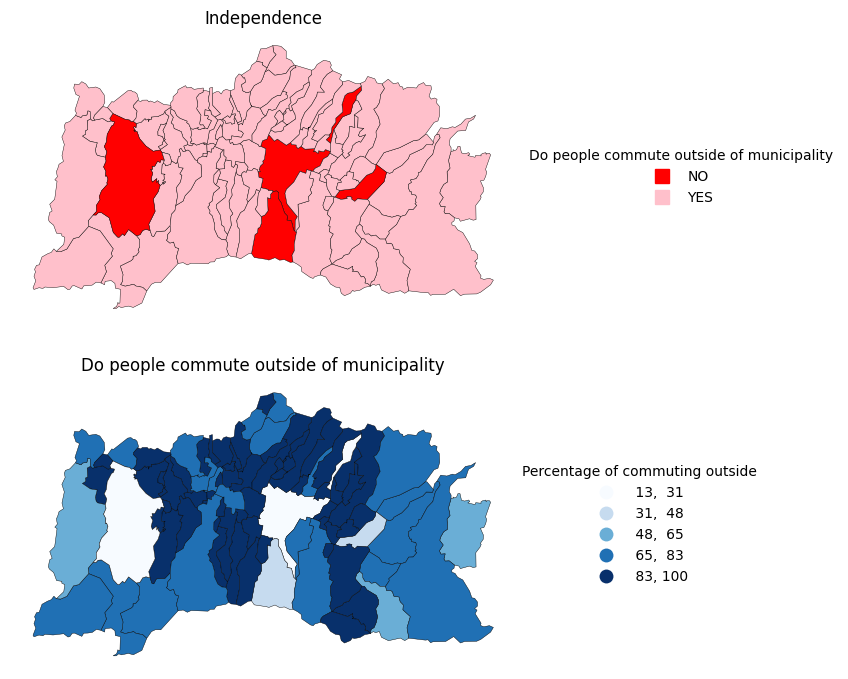

In [9]:
import geopandas as gpd
import pandas as pd
import numpy as np
# from numpy import infinity
import mapclassify
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib .patches import Patch, Rectangle
from shapely.geometry import Point
from shapely.geometry import LineString

commute = pd.read_csv(r"../data/sodb_2021_dochadzka_denne_lm_rk.csv", encoding="windows-1250")

map2 = gpd.read_file(r"../data/geo/liptov.shp")
map2.drop(columns = ["DOW", "FACC", "IDN3", "NM3", "IDN2", "NM2", "NUTS1", "NUTS1_CODE", "NUTS2", "NUTS2_CODE", "NUTS3", "NUTS3_CODE", "LAU1", "LAU1_CODE", "LAU2", "LAU2_CODE", "VYMERA", "Shape_Area", "Shape_Leng"], inplace = True)

commute[["obecA", "obecB"]] = commute[["obecA", "obecB"]].astype(str)
commute["pocet"] = commute["pocet"].astype(int)
map2["IDN4"] = map2["IDN4"].astype(str)
all = (
    commute
    .groupby("obecA", group_keys = False)["pocet"]
    .sum()
)
outer = (
    commute[commute["obecA"] != commute["obecB"]]
    .groupby("obecA", group_keys=False)["pocet"]
    .sum()
)
inter = (
    commute[commute["obecA"] == commute["obecB"]]
    .groupby("obecA", group_keys=False)["pocet"]
    .sum()
)

all_df = all.reset_index().rename(columns = {"pocet": "spolu"})
inter_df = inter.reset_index().rename(columns = {"pocet": "v_obci"})
outer_df = outer.reset_index().rename(columns = {"pocet": "mimo_obce"})

table = all_df.merge(
    outer_df.merge(
    inter_df,
    on = "obecA",
    how = "left"
), on = "obecA", how = "left").fillna(0)
# print(outer.head())
# print(inter)

table["mimo_obce_percent"] = table["mimo_obce"]/table["spolu"]*100
table["v_obci_percent"] = table["v_obci"]/table["spolu"]*100
table["independence"] = table["v_obci"] > table["mimo_obce"]

tablemap2 = map2.merge(
    table,
    left_on = "IDN4",
    right_on = "obecA",
    how = "left"
)

print(tablemap2)
color_dict_i = {True: "red", False: "pink"}

plt.figure(figsize = (11.69, 8.27))
plt.subplot(2, 1, 1)
tablemap2.plot(
    ax = plt.gca(),
    color = tablemap2["independence"].map(color_dict_i),
    edgecolor = "black",
    linewidth = 0.3
)
handles_i = [
    plt.Line2D(
        [0], [0],
        marker = "s",
        markersize = 10,
        linestyle = "None",
        color = color,
        # edgecolor = "black",
        label = "NO" if key else "YES"
        )
        for key, color in color_dict_i.items()
]
plt.legend(
    handles = handles_i,
    title = "Do people commute outside of municipality",
    loc = "center left",
    bbox_to_anchor = (1, 0.5),
    frameon = False
)
plt.title("Independence")
plt.axis(False)


tablemap2["interval"] = pd.cut(tablemap2["mimo_obce_percent"], bins = 5, labels = False)
plt.subplot(2, 1, 2)
tablemap2.plot(
    ax = plt.gca(),
    column = "mimo_obce_percent",
    cmap = "Blues",
    legend = True,
    edgecolor = "black",
    linewidth = 0.3,
    scheme = "equalinterval",
    k = 5,
    legend_kwds = {
        "title": "Percentage of commuting outside",
        "loc": "right",
        "fmt": "{:.0f}",
        "frameon": False,
        "bbox_to_anchor": (1.5, 0.5)
    }
)
# handles_mimo = [
#     plt.Line2D(
#         [0], [0],
#         marker = "s",
#         markersize = 10,
#         linestyle = "None",
#         color = color,
#         # edgecolor = "black",
#         label = "NO" if key else "YES"
#         )
#         for key, color in color_dict_i.items()
# ]
# plt.legend(
#     # handles = handles_i,
#     title = "Independence",
#     loc = "center left",
#     bbox_to_anchor = (1, 0.5),
#     frameon = False
# )
plt.title("Do people commute outside of municipality")
plt.axis(False)
plt.savefig("../result_maps/test_LM_RK_3.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()

       IDN4             NM4  \
81   510271      Beňadiková   
82   510301        Bešeňová   
83   510319       Bobrovček   
84   510327        Bobrovec   
85   510335       Bobrovník   
..      ...             ...   
157  511153          Vlachy   
158  511170        Východná   
159  511188      Vyšná Boca   
160  511196  Závažná Poruba   
161  511200            Žiar   

                                              geometry   obecA  spolu  \
81   POLYGON Z ((-373683.9 -1192066.05 0, -374163.7...  510271    141   
82   POLYGON Z ((-391918.29 -1186162.77 0, -391612....  510301    108   
83   POLYGON Z ((-381328.4 -1184368.22 0, -381146.0...  510319     42   
84   POLYGON Z ((-374953 -1176994 0, -374717.99 -11...  510327    423   
85   POLYGON Z ((-389437.71 -1186591.51 0, -389331....  510335     19   
..                                                 ...     ...    ...   
157  POLYGON Z ((-391735.47 -1188792.17 0, -391237....  511153    149   
158  POLYGON Z ((-352394.5 -1186002.1 0, -3

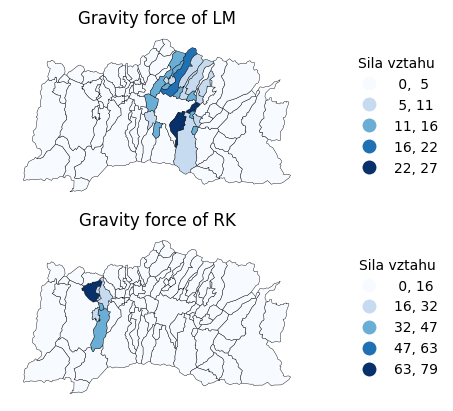

In [ ]:
distance = pd.read_csv(r"../data/vzdialenost_obce.csv", sep = ";")
# print(distance)
distance["obec_id"] = distance["obec_id"].astype(str)
dist = tablemap2.merge(
    distance,
    left_on = "obecA",
    right_on = "obec_id",
    how = "right" 
)

dist["strength"] = ((dist["pocet_dochadzajucich"]/dist["spolu"]*100)/dist["vzdialenost_km"]**2)*10
# dist.to_csv("../data/test1.csv")
dist_lm = (
    dist[dist["mesto_id"] == 510262]
).replace(np.inf, 0, inplace = False)
dist_rk = (
    dist[dist["mesto_id"] == 510998]
).replace(np.inf, 0, inplace = False)
print(dist_rk)
plt.figure(figsize = (11.69, 8.27))
# Gravity force of LM
plt.subplot(2, 1, 1)
dist_lm["interval"] = pd.cut(dist_lm["strength"], bins = 5, labels = False)
dist_lm.plot(
    ax = plt.gca(),
    column = "strength",
    cmap = "Blues",
    legend = True,
    edgecolor = "black",
    linewidth = 0.3,
    scheme = "equalinterval",
    k = 5,
    legend_kwds = {
        "title": "Sila vztahu",
        "loc": "right",
        "fmt": "{:.0f}",
        "frameon": False,
        "bbox_to_anchor": (1.5, 0.5)
    }
)
plt.title("Gravity force of LM")
plt.axis(False)

# Gravity force of RK
plt.subplot(2, 1, 2)
dist_rk["interval"] = pd.cut(dist_rk["strength"], bins = 5, labels = False)
dist_rk.plot(
    ax = plt.gca(),
    column = "strength",
    cmap = "Blues",
    legend = True,
    edgecolor = "black",
    linewidth = 0.3,
    scheme = "equalinterval",
    k = 5,
    legend_kwds = {
        "title": "Sila vztahu",
        "loc": "right",
        "fmt": "{:.0f}",
        "frameon": False,
        "bbox_to_anchor": (1.5, 0.5)
    }
)
plt.title("Gravity force of RK")
plt.axis(False)
plt.savefig("../result_maps/test_LM_RK_4.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()